In [1]:
# 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
print(torch.backends.mps.is_available())   # should be True on M-series


True


In [2]:
# 2. Load Classification Dataset
classification_df = pd.read_csv("../data/classification_data.csv")
classification_df.head()

,id,text,label
0,1,DrugZ caused severe rashes in some participants.,Adverse Effect
1,2,No significant side effects were observed duri...,Positive Outcome
2,3,Participants were monitored every two weeks.,Neutral Observation
3,4,Increased liver enzymes were noted post-treatm...,Adverse Effect
4,5,Patients were instructed to maintain a food di...,Neutral Observation


In [3]:
classification_df['label'].value_counts().sort_index()

label
Adverse Effect         352
Neutral Observation    335
Positive Outcome       313
Name: count, dtype: int64

In [4]:
# 3. Encode Labels
label_encoder = LabelEncoder()
classification_df['label_encoded'] = label_encoder.fit_transform(classification_df['label'])
classification_df.head()

,id,text,label,label_encoded
0,1,DrugZ caused severe rashes in some participants.,Adverse Effect,0
1,2,No significant side effects were observed duri...,Positive Outcome,2
2,3,Participants were monitored every two weeks.,Neutral Observation,1
3,4,Increased liver enzymes were noted post-treatm...,Adverse Effect,0
4,5,Patients were instructed to maintain a food di...,Neutral Observation,1


In [5]:
# 4. Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    classification_df['text'].tolist(),
    classification_df['label_encoded'].tolist(),
    test_size=0.2,
    random_state=42
)

for i in range(5):
    print(f"Train Text: {train_texts[i]}")
    print(f"Train Label: {train_labels[i]}")
    print()

Train Text: No significant side effects were observed during the trial.
Train Label: 2

Train Text: Participants showed improved lung function after therapy with DrugC.
Train Label: 2

Train Text: Severe allergic reactions were observed following DrugB administration.
Train Label: 0

Train Text: Patients were instructed to maintain a food diary.
Train Label: 1

Train Text: Participants were monitored every two weeks.
Train Label: 1



In [6]:
# 5. Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [7]:
# 6. Dataset Class
torch.backends.cuda.matmul.allow_tf32 = True

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ClassificationDataset(train_encodings, train_labels)
val_dataset = ClassificationDataset(val_encodings, val_labels)

In [8]:
# 7. Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# 8. Training Arguments
training_args = TrainingArguments(
    output_dir="../results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_dir="../logs",
    logging_steps=100,
    save_strategy="no",
    load_best_model_at_end=False,
)

In [10]:
# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
# 10. Train
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.047220
2,0.256100,0.008397
3,0.256100,0.004231
4,0.006000,0.002597
5,0.006000,0.001765
6,0.002500,0.001276
7,0.002500,0.000972
8,0.001400,0.000766


In [ ]:
# 11. Evaluation
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.0008448421722277999, 'eval_runtime': 0.1886, 'eval_samples_per_second': 1060.349, 'eval_steps_per_second': 68.923, 'epoch': 10.0}


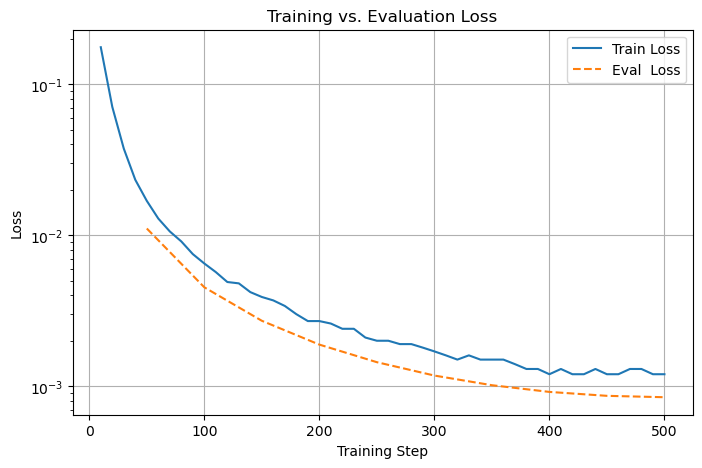

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Pull out the log history
hist = pd.DataFrame(trainer.state.log_history)

# 2) Separate train-loss and eval-loss entries
train_df = hist[hist['loss'].notnull()]
eval_df  = hist[hist['eval_loss'].notnull()]

# 3) One figure, two curves
plt.figure(figsize=(8,5))
plt.plot(train_df['step'], train_df['loss'],     label='Train Loss')
plt.plot(eval_df ['step'], eval_df ['eval_loss'], label='Eval  Loss', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training vs. Evaluation Loss')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()
